In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import collections
import networkx as nx
import numpy as np
from collections import defaultdict
import sys
sys.path.insert(1, "/home/giga/trips")
from trips_module.utils import *
from analysis.evaluation1 import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import mannwhitneyu, normaltest

import warnings
warnings.filterwarnings("ignore")

# Load prelims

In [3]:
# Set colors
cmap = mpl.pyplot.get_cmap('YlGn_r', 8)
all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba)) # rgb2hex accepts rgb or rgba
colors_pcsf = all_colors[3:]

cmap = cm.get_cmap('OrRd_r', 8)

all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_diam = all_colors[3:]

cmap = cm.get_cmap('PuBu_r', 8)

all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_trips = all_colors[3:]

cmap = cm.get_cmap('PiYG', 20)
all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_trips_dir = all_colors[3:]

cmap = cm.get_cmap('OrRd_r', 8)
all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_regenrich = all_colors[3:]

cmap = cm.get_cmap('BuPu_r', 8)
all_colors = []
for i in range(cmap.N):
    rgba = cmap(i)
    all_colors.append(mpl.colors.rgb2hex(rgba))
colors_degs_pcst = all_colors[3:]

# Create custom color map for DIAMOnD+PCST workflow
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom",
        ["white","salmon"], N=5)
colors_diamond = []
for i in range(cmap.N):
    rgba = cmap(i)
    colors_diamond.append(mpl.colors.rgb2hex(rgba))
colors_diamond = colors_diamond[::-1]

# Create custom color map for MOGAMUN workflow
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom",
        ["white","darkcyan"], N=5)
colors_mogamun = []
for i in range(cmap.N):
    rgba = cmap(i)
    colors_mogamun.append(mpl.colors.rgb2hex(rgba))
colors_mogamun = colors_mogamun[::-1]

dict_palettes = {"degs_dorothea":"BuPu_r",
                 "domino_dorothea":"PuBu_r",
                 "regenrich_dorothea":"OrRd_r",
                "pcsf":"YlGn_r",
                "diamond": "summer_r"}

dict_colors = {"degs_dorothea":colors_degs_pcst[0],
              "domino_dorothea":colors_trips[0],
              "regenrich_dorothea":colors_regenrich[0],
              "pcsf":colors_pcsf[0],
              "domino_dorothea_directed":colors_trips_dir[0],
              "diamond":colors_diamond[0],
              "mogamun":colors_mogamun[0]}

dict_colors_int = {"degs_dorothea":colors_degs_pcst[1],
              "domino_dorothea":colors_trips[1],
              "regenrich_dorothea":colors_regenrich[1],
              "pcsf":colors_pcsf[1]}

my_colors = [ dict_colors["domino_dorothea"], dict_colors_int["domino_dorothea"],
             dict_colors["regenrich_dorothea"], dict_colors_int["regenrich_dorothea"],
             dict_colors["pcsf"], dict_colors_int["pcsf"],"red"]

In [6]:
def load_combined_solutions_indiv(target_folder, dataset):

    """
    Combines the TRIPS result for a dataset
    target_folder:  Should contain the *_pcst.txt files after running TRIPS for the dataset
    dataset: keyword or dataset name that should match those in the output folder
    """

    files = glob.glob(os.path.join(target_folder, "{}_module_[0-9]*_pcst.txt".format(dataset)))
    indices = [int(f.split("module_")[1].split("_pcst")[0]) for f in files]
    all_solns = []

    G_big = nx.Graph()
    if indices:
        if len(set(indices)) == 1:
            file_undirected = os.path.join(target_folder, "{}_module_{}_pcst.txt".format(dataset, indices[0]))
            if os.path.exists(file_undirected):
                df = pd.read_csv(file_undirected, sep="\t")
                G_undirected = nx.from_pandas_edgelist(df, "source", "target", create_using=nx.Graph)
                all_solns.append(list(G_undirected.nodes()))
        else:
            max_index = max(indices)
            for index in range((max_index+1)):
                file_undirected = os.path.join(target_folder, "{}_module_{}_pcst.txt".format(dataset, index))
                if os.path.exists(file_undirected):
                    df = pd.read_csv(file_undirected, sep="\t")
                    G_undirected = nx.from_pandas_edgelist(df, "source", "target", create_using=nx.Graph)
                    all_solns.append(list(G_undirected.nodes()))

    return all_solns

In [56]:
# Load list of TFs
file_tfs = r"/data2/home/giga/TRIPS_results/ZENODO/TF_names_v_1.01.txt"
df_tf = pd.read_csv(file_tfs, sep="\t", header=None)
df_tf.columns = ["tf"]
all_tfs = list(df_tf["tf"])

# Morabito et al. dataset - microglia

In [59]:
# Load gold standard for the Morabito dataset
file1 = r"/data2/home/giga/TRIPS_results/ZENODO/Supp_table_1b.csv"
df = pd.read_csv(file1, sep=" ", skiprows=2)
df = df[df["cell_type"] == "MG"]
all_tf_targets = list(df["motif_name"])
atac_seq_results = (set(all_tf_targets).intersection(set(all_tfs)))

In [60]:
folder_morabito = r"/data2/home/giga/TRIPS_results/ZENODO/single_cell_datasets/Alzheimers_Morabito_microglia/"

## DEGs

In [61]:
file_degs = os.path.join(folder_morabito, "degs", "degs_GSE174367_microglia.txt")
df = pd.read_csv(file_degs, sep="\t")
df = df[df["AdjPValue"] < 0.05]
df = df[abs(df["Log_FoldChange"]) > 0.25]
degs = list(df["Gene_symbol"])
degs_tfs = list(set(degs).intersection(set(all_tfs)))
set(degs_tfs).intersection(set(atac_seq_results))

{'FOXP2', 'RORA'}

## TRIPS

In [62]:
parent_folder = os.path.join(folder_morabito, "trips")
dataset = "GSE174367_microglia"
indiv_solns = load_combined_solutions_indiv(parent_folder, dataset)

res_trips = set(flatten(indiv_solns)).intersection(set(all_tfs))
common_trips = set(res_trips).intersection(set(atac_seq_results))
print(len(common_trips) / len(res_trips))
print(common_trips)

0.5833333333333334
{'FOS', 'GATA3', 'STAT1', 'CEBPA', 'TFAP2C', 'NFKB1', 'GATA2'}


## RegEnrich

In [63]:
parent_folder = os.path.join(folder_morabito, "regenrich")
regenrich_morabito = extract_regenrich_results(parent_folder, "kidney_yes_MG", n_top_reg=25)
common = list(set(regenrich_morabito).intersection(set(atac_seq_results)))
print("RegEnrich TFs:", " ".join(common))

RegEnrich TFs: STAT3 FOS CEBPA STAT1 ETS1 MEF2A FOXP1 CTCF ESR1 FOXA1 GATA3 TFAP2C TP53 GATA2 SPI1


## MOGAMUN

In [64]:
parent_folder = os.path.join(folder_morabito, "mogamun")
file = os.path.join(parent_folder, "A_ALL_FILTERED_INTERACTIONS_CYTOSCAPE.csv")
soln = extract_mogamun_results(file)
soln = set(soln).intersection(set(all_tfs))
common = list(set(soln).intersection(set(atac_seq_results)))
print("MOGAMUN TFs:", " ".join(common))

MOGAMUN TFs: YY1 ETS1 CTCF ESR1 NFKB1 SPI1 TP53 FOS STAT1 POU2F1 MYC NFATC2 SMAD3 GATA3 GATA2 STAT3 CEBPA FOXP1 VDR FOXA1 JUN TFAP2C RARA


## CaCTS

In [65]:
parent_folder = os.path.join(folder_morabito, "cacts")
file = os.path.join(parent_folder, "ad_morabito_MG_filtered_top0.1.txt")
print(os.path.exists(file))
res = extract_cacts_results(file)
res_cacts = [i for i in res if i in all_tfs]
common = list(set(res_cacts).intersection(set(atac_seq_results)))
print("CaCTS TFs:", ", ".join(common))

True
CaCTS TFs: STAT3, CREB1, ETV6, SMAD3, FOXK2, NRF1, ELF1, NFATC2, PBX3, HIF1A, POU2F2, NFKB1, RBPJ, REL, NR3C1


## PCSF

In [66]:
parent_folder = os.path.join(folder_morabito, "pcsf")
n_mech = 6

file = os.path.join(parent_folder, "morabito_ad_{}_edges.txt".format(n_mech))
res_pcsf = extract_pcsf_results(file)
res_pcsf

[]

# Xu et al. - Homeostatic microglia

In [67]:
folder_micr0 = r"/data2/home/giga/TRIPS_results/ZENODO/single_cell_datasets/Alzheimers_Xu_micr0/"

## RegEnrich

In [68]:
file = os.path.join(folder_micr0, "regenrich", "xuetal_micr0_rankscore_GSEA.txt")
df = pd.read_csv(file, sep="\t").head(25)
res_regenrich = list(df.reg)
print("RegEnrich TFs:", ", ".join(res_regenrich))

RegEnrich TFs: STAT1, STAT2, STAT3, BACH1, FOXP1, NFKB1, IRF1, ESR1, RUNX1, TAL1, FOS, ETS1, SP1, CEBPA, TP53, EGR1, E2F1, SPI1, CTCF, MITF, HIF1A, GATA2, RELA, FOXA1, GATA3


## CaCTS

In [69]:
file = os.path.join(folder_micr0, "cacts", "xuetal_micr0_filtered_top0.1.txt")
res_cacts = extract_cacts_results(file)
print("No. of TFs:", len(res_cacts))
print("CaCTS TFs:", ", ".join(res_cacts))

No. of TFs: 50
CaCTS TFs: ZBTB16, ZFHX3, BNC2, FOXO3, MBNL2, FOXP1, ZNF652, BHLHE41, FLI1, ZNF846, NCOA3, MXD4, RFX3, BAZ2B, ZEB1, MEF2C, MAF, BBX, ZBTB1, ZNF207, NCOA2, RUNX2, GATAD2B, FOXN3, ZNF148, ZNF609, SKI, BPTF, ZNF618, NFIA, FOXP2, ZBTB20, TET2, ZNF280D, CREB1, SPEN, ZNF518A, TET3, NRF1, SON, LCORL, ZNF33A, FOXJ3, AEBP2, REL, RFX7, TCF7L2, ARID2, SMYD3, ZZZ3


## PCSF

In [70]:
file = os.path.join(folder_micr0, "pcsf", "micr0_6_edges.txt")
res_pcsf = extract_pcsf_results(file)
res_pcsf = [i for i in res_pcsf if i in all_tfs]
print("PCSF TFs:", ", ".join(res_pcsf))

PCSF TFs: MAFB, STAT2, BACH1, ETV6, STAT1, PPARA


## MOGAMUN

In [71]:
file = os.path.join(folder_micr0, "mogamun", "A_ALL_FILTERED_INTERACTIONS_CYTOSCAPE.csv")
res_mogamun = extract_mogamun_results(file)
res_mogamun = [tf for tf in res_mogamun if tf in all_tfs]
print("MOGAMUN TFs:", ", ".join(res_mogamun))

MOGAMUN TFs: FOS, ETS1, CUX1, FOXA1, FOXO3, FOXP1, GATA3, MYC, NFKB1, RUNX1, SMAD3, STAT3, TP53, CEBPA, E2F1, JUN, AR, ESR1, ETV6, SP1, MITF, BCL6, SPI1, IRF1, STAT1, HNF4A, TAL1, IRF9, STAT2, GATA2


## TRIPS

In [72]:
parent_folder = os.path.join(folder_micr0, "trips")
dataset = "Micr0_ADvsCtrl"
indiv_solns = load_combined_solutions_indiv(parent_folder, dataset)
res_trips = list(set(flatten(indiv_solns)))
res_trips = [tf for tf in res_trips if tf in all_tfs]
print("TRIPS TFs:", ", ".join(res_trips))

TRIPS TFs: IRF1, ESR1, NFKB1, SPI1, HNF4A, FOS, STAT1, MYC, GATA3, STAT3, RUNX1, FOXP1, HIF1A, CEBPA, PPARG


## Plot

In [73]:
data = {"trips": res_trips, "regenrich": res_regenrich, 
        "pcsf":res_pcsf, "cacts": res_cacts, "mogamun": res_mogamun}

labels = list(data.keys())
result = [[jaccard_similarity(data[row], data[col]) for col in labels]
          for row in labels]

df = pd.DataFrame(result, columns = labels)

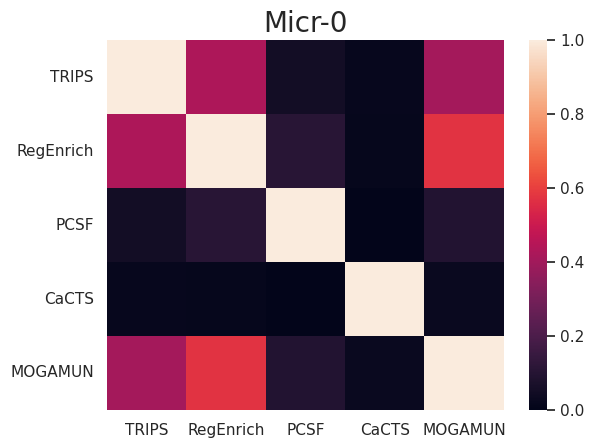

In [74]:
g = sns.heatmap(df)
labels = ["TRIPS","RegEnrich","PCSF","CaCTS","MOGAMUN"]
g.set_yticklabels(labels, rotation=0)
g.set_xticklabels(labels, rotation=0)
plt.title("Micr-0", fontsize=20)
# g.yticks(rotation=0)

file = r"/data2/home/giga/TRIPS_results/ZENODO/single_cell_datasets/xu_jaccard_micr0.svg"
plt.savefig(file, format="svg", bbox_inches="tight")

# Xu et al. - Activated microglia

In [75]:
folder_micr1 = r"/data2/home/giga/TRIPS_results/ZENODO/single_cell_datasets/Alzheimers_Xu_micr1/"

## RegEnrich

In [76]:
file = os.path.join(folder_micr1, "regenrich", "xuetal_micr1_rankscore_GSEA.txt")
df = pd.read_csv(file, sep="\t")
df = df.head(25)
res_regenrich = list(df.reg)
print("RegEnrich TFs:", ", ".join(res_regenrich))

RegEnrich TFs: STAT1, FOXP1, TAL1, GATA2, CEBPA, FOS, RUNX1, GATA3, CTCF, SPI1, FOXO3, MEF2C, ERG, STAT2, FOXA1, HNF4A, E2F4, FLI1, E2F1, NFYB, AR, BCL6, PPARG, TFAP2C, BACH1


## CaCTS

In [77]:
file = os.path.join(folder_micr1, "cacts", "xuetal_micr1_filtered_top0.1.txt")
res_cacts = extract_cacts_results(file, n_top_reg=25)
print("No. of TFs:", len(res_cacts))
print("CaCTS TFs:", ", ".join(res_cacts))

No. of TFs: 25
CaCTS TFs: ZBTB16, BNC2, MAF, FOXP1, FOXO3, ZNF846, ZFHX3, PPARG, FLI1, RUNX2, MBNL2, RFX3, MXD4, ZNF652, NFIA, JDP2, NCOA3, ADNP, ZNF710, MEF2C, SKIL, BBX, ATF6, BHLHE41, TET2


## PCSF

In [78]:
n_mech = 6
file_pcsf = os.path.join(folder_micr1, "pcsf", "micr1_{}_edges.txt".format(n_mech))
res_pcsf = extract_pcsf_results(file_pcsf)
res_pcsf = [i for i in res_pcsf if i in all_tfs]
print("No. of TFs:", len(res_pcsf))
", ".join(res_pcsf)

No. of TFs: 6


'JUNB, MAFB, STAT2, FOXO4, ETV6, STAT1'

## MOGAMUN

In [79]:
parent_folder = os.path.join(folder_micr1, "mogamun", "A_ALL_FILTERED_INTERACTIONS_CYTOSCAPE.csv")
res_mogamun = extract_mogamun_results(parent_folder)
len(res_mogamun)

res_mogamun = [tf for tf in res_mogamun if tf in all_tfs]
print("No. of TFs:", len(res_mogamun))
", ".join(res_mogamun)

No. of TFs: 36


'FOS, EPAS1, ETS1, CUX1, FOXP1, GATA3, MYC, NFKB1, RUNX1, SMAD3, STAT3, TP53, CEBPA, E2F1, JUN, HIF1A, RARA, AR, RELA, ESR1, ETV6, SP1, TFAP2C, SPI1, CTCF, IRF1, EGR1, STAT1, HNF4A, CREB1, MITF, TAL1, IRF9, STAT2, ZNF398, E2F4'

## TRIPS

In [80]:
parent_folder = os.path.join(folder_micr1, "trips")
dataset = "Micr1_ADvsCtrl"
indiv_solns = load_combined_solutions_indiv(parent_folder, dataset)
res_trips = set(flatten(indiv_solns)).intersection(set(all_tfs))
print("No. of TFs: ", len(res_trips))
", ".join(res_trips)

No. of TFs:  18


'IRF1, STAT2, FOS, CEBPA, HNF4A, FOXO3, STAT1, TP53, ERG, FOXP1, MYC, HIF1A, FOXA1, TAL1, TFAP2C, NFKB1, ZNF550, SPI1'

## Plot

In [81]:
data = {"trips": res_trips, "regenrich": res_regenrich, 
        "pcsf":res_pcsf, "cacts": res_cacts, "mogamun": res_mogamun}

labels = list(data.keys())
result = [[jaccard_similarity(data[row], data[col]) for col in labels]
          for row in labels]

df = pd.DataFrame(result, columns = labels)

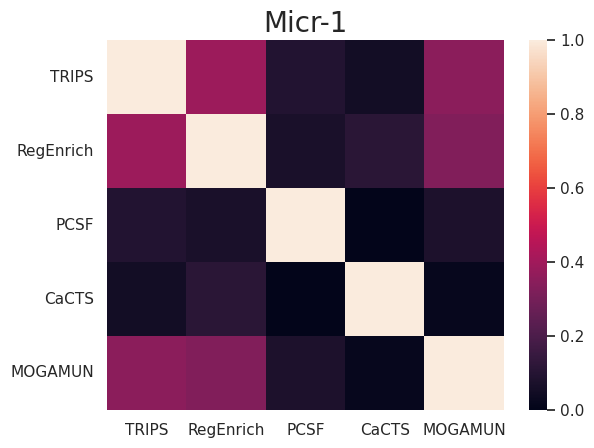

In [82]:
g = sns.heatmap(df)
labels = ["TRIPS","RegEnrich","PCSF","CaCTS","MOGAMUN"]
g.set_yticklabels(labels, rotation=0)
g.set_xticklabels(labels, rotation=0)
plt.title("Micr-1", fontsize=20)
# g.yticks(rotation=0)

file = r"/data2/home/giga/TRIPS_results/ZENODO/single_cell_datasets/xu_jaccard_micr1.svg"
plt.savefig(file, format="svg", bbox_inches="tight")

# Diabetic kidney disease

In [85]:
file_cell_types = r"/data2/home/giga/TRIPS_results/ZENODO/dkd_cell_types.txt"
df_cells = pd.read_csv(file_cell_types, sep="\t")
all_cell_types = list(set(df_cells["author_cell_type"]))
cell_types_remove = ["MES","PT","LEUK","FIB"]
all_cell_types = [x for x in all_cell_types if x not in cell_types_remove]
print(len(all_cell_types))

12


In [84]:
# Extract gold standard
folder_atac_seq = r"/data2/home/giga/TRIPS_results/ZENODO/atac_seq_tf_enrichment/"

folder_dkd = r"/data2/home/giga/TRIPS_results/ZENODO/single_cell_datasets/Diabetic_kidney_disease/"

## DEGs

In [34]:
parent_folder = os.path.join(folder_dkd, "degs")

precs_degs = []
for cell_type in all_cell_types:

    file_degs = os.path.join(parent_folder, "kidney_yes_{}.csv".format(cell_type))
    df = pd.read_csv(file_degs, sep="\t")
    df = df[df["p_val"] < 0.05]
    df = df[abs(df["Log_FoldChange"]) > 0.25]
    degs = list(df["Gene_symbol"])
    degs_tfs = set(degs).intersection(set(all_tfs))

    if cell_type == "PTVCAM1":
        atac_cell_type = "pt_vcam1"
    else:
        atac_cell_type = cell_type
            
    gold_standard_tfs = []
    file_atac = os.path.join(folder_atac_seq, "kidney_yes_supp_dataset_13_{}.csv".format(atac_cell_type.lower()))
    df_atac = pd.read_csv(file_atac, sep="\t")
    gold_standard_tfs = df_atac["motif.name"]

    if degs_tfs:
        common = set(degs_tfs).intersection(set(gold_standard_tfs))
        prec = len(common) / len(degs_tfs)
    else:
        prec = 0
    precs_degs.append(prec)

precs_degs

[0.39759036144578314,
 0.4782608695652174,
 0.47191011235955055,
 0.475,
 0.42105263157894735,
 0.4307692307692308,
 0.575,
 0.3333333333333333,
 0.5227272727272727,
 0.3695652173913043,
 0.532258064516129,
 0.3424657534246575]

## CaCTS

In [35]:
parent_folder = os.path.join(folder_dkd, "cacts")
percent = 0.1

precs_cacts = []
for cell_type in all_cell_types:
    
        file = os.path.join(parent_folder, "kidney_yes_{}_filtered_top{}.txt".format(cell_type, percent))
        res = extract_cacts_results(file)
        res_cacts = [i for i in res if i in all_tfs]
        if cell_type == "PTVCAM1":
            atac_cell_type = "pt_vcam1"
        else:
            atac_cell_type = cell_type
        gold_standard_tfs = []
        file_atac = os.path.join(folder_atac_seq, "kidney_yes_supp_dataset_13_{}.csv".format(atac_cell_type.lower()))
        df_atac = pd.read_csv(file_atac, sep="\t")
        gold_standard_tfs = df_atac["motif.name"]
        if res_cacts:
            common = set(res_cacts).intersection(set(gold_standard_tfs))
            prec = len(common) / len(res_cacts)
        else:
            prec = 0
        precs_cacts.append(prec)

## RegEnrich

In [36]:
parent_folder = os.path.join(folder_dkd, "regenrich")

precs_regenrich = []
for cell_type in all_cell_types:

    keyword = "kidney_yes_{}".format(cell_type)
    res = extract_regenrich_results(parent_folder, keyword, n_top_reg=25)
    if cell_type == "PTVCAM1":
        atac_cell_type = "pt_vcam1"
    else:
        atac_cell_type = cell_type
        
    gold_standard_tfs = []
    file_atac = os.path.join(folder_atac_seq, "kidney_yes_supp_dataset_13_{}.csv".format(atac_cell_type.lower()))
    df_atac = pd.read_csv(file_atac, sep="\t")
    gold_standard_tfs = df_atac["motif.name"]

    common = (set(res).intersection(set(gold_standard_tfs)))
    precs_regenrich.append(len(common) / len(res))

## TRIPS

In [37]:
parent_folder = os.path.join(folder_dkd, "trips")

precs_trips = []
trips_solutions = []
for cell_type in all_cell_types:

    dataset = "kidney_yes_{}".format(cell_type)    
    results_folder = os.path.join(parent_folder, dataset, "final_solutions_{}".format(dataset))
    indiv_solns = load_combined_solutions_indiv(results_folder, dataset)

    res_trips = flatten(indiv_solns)
    trips_solutions.append(res_trips)
    trips_tfs = set(res_trips).intersection(set(all_tfs))

    if cell_type == "PTVCAM1":
        atac_cell_type = "pt_vcam1"
    else:
        atac_cell_type = cell_type
    gold_standard_tfs = []
    file_atac = os.path.join(folder_atac_seq, "kidney_yes_supp_dataset_13_{}.csv".format(atac_cell_type.lower()))
    df_atac = pd.read_csv(file_atac, sep="\t")
    gold_standard_tfs = df_atac["motif.name"]
    common = set(trips_tfs).intersection(set(gold_standard_tfs))
    if len(trips_tfs) == 0:
        precs_trips.append(0)
    else:
        precs_trips.append(len(common) / len(trips_tfs))

## PCSF

In [38]:
parent_folder = os.path.join(folder_dkd, "pcsf")
keyword = "test"
n_mech = 6

precs_pcsf = []
for cell_type in all_cell_types:

    file = os.path.join(parent_folder, "kidney_yes_{}".format(cell_type), "{}_{}_edges.txt".format(keyword, n_mech))
    # print("file", file)
    if not os.path.exists(file):
        print("File does not exist for", cell_type)
    else:   
        res_pcsf = extract_pcsf_results(file)
        if cell_type == "PTVCAM1":
            atac_cell_type = "pt_vcam1"
        else:
            atac_cell_type = cell_type
        gold_standard_tfs = []
        file_atac = os.path.join(folder_atac_seq, "kidney_yes_supp_dataset_13_{}.csv".format(atac_cell_type.lower()))
        df_atac = pd.read_csv(file_atac, sep="\t")
        gold_standard_tfs = df_atac["motif.name"]
        
        res_tfs = set(res_pcsf).intersection(set(all_tfs))
        common = set(res_tfs).intersection(set(gold_standard_tfs))
        if res_pcsf:
            prec = len(common) / len(res_pcsf)
        else:
            prec = 0
        precs_pcsf.append(prec)

precs_pcsf

[0.32558139534883723,
 0.2,
 0.2727272727272727,
 0.3548387096774194,
 0,
 0.20454545454545456,
 0.3333333333333333,
 0.25,
 0.4,
 0.2857142857142857,
 0.4117647058823529,
 0.3333333333333333]

## MOGAMUN

In [39]:
parent_folder = os.path.join(folder_dkd, "mogamun")

precs_mogamun = []
for cell_type in all_cell_types:

    dataset = "kidney_yes_" + cell_type
    folder_sub = glob.glob(os.path.join(parent_folder, dataset, "Experiment_*".format(dataset)))
    if len(folder_sub) == 1:
        file = os.path.join(folder_sub[0], "A_ALL_FILTERED_INTERACTIONS_CYTOSCAPE.csv")
        if os.path.exists(file):
            soln = extract_mogamun_results(file)
        if cell_type == "PTVCAM1":
            atac_cell_type = "pt_vcam1"
        else:
            atac_cell_type = cell_type
        gold_standard_tfs = []
        file_atac = os.path.join(folder_atac_seq, "kidney_yes_supp_dataset_13_{}.csv".format(atac_cell_type.lower()))
        df_atac = pd.read_csv(file_atac, sep="\t")
        gold_standard_tfs = df_atac["motif.name"]
        
        res_mogamun = set(soln).intersection(set(all_tfs))
        common = set(res_mogamun).intersection(set(gold_standard_tfs))
        if res_mogamun:
            prec = len(common) / len(res_mogamun)
        else:
            prec = 0
        precs_mogamun.append(prec)

precs_mogamun

[0.7837837837837838,
 0.8235294117647058,
 0.8484848484848485,
 0.8,
 0.78125,
 0.8235294117647058,
 0.8292682926829268,
 0.8,
 0.8695652173913043,
 0.8823529411764706,
 0.9259259259259259,
 0.8333333333333334]

## Plot

In [40]:
dict_map = {"degs": precs_degs,
            "trips": precs_trips,
            "regenrich": precs_regenrich,
            "cacts": precs_cacts,
            "pcsf": precs_pcsf,
            "mogamun": precs_mogamun}

all_dfs = []
for method, precs in dict_map.items():
    df = pd.DataFrame({"precision":precs})
    df["method"] = method
    all_dfs.append(df)

df_all = pd.concat(all_dfs)
df_all.head()

,precision,method
0,0.397590,degs
1,0.478261,degs
2,0.471910,degs
3,0.475000,degs
4,0.421053,degs


In [41]:
my_colors = ["palevioletred",
             dict_colors["domino_dorothea"],
             dict_colors["regenrich_dorothea"],
             "tan",
             dict_colors["pcsf"],
            "orchid"]

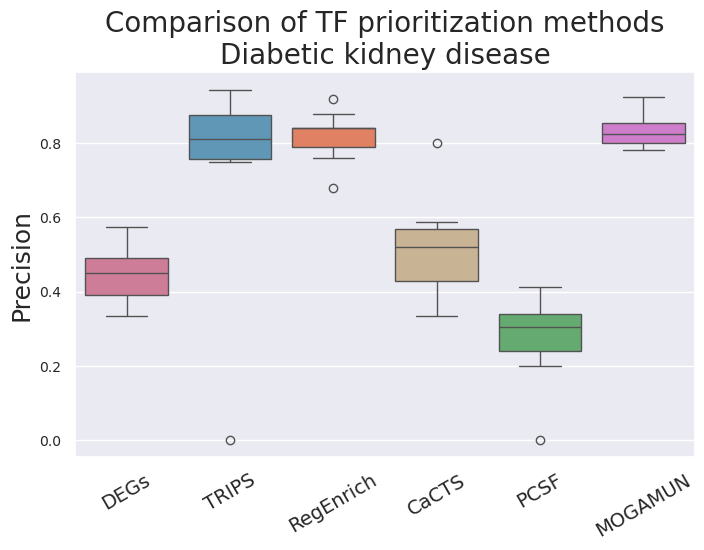

In [42]:
sns.set()
plt.figure(figsize=(8,5))
b = sns.boxplot( data=df_all, x="method", y="precision",  palette=my_colors)  # RUN PLOT  
b.axes.set_title("Comparison of TF prioritization methods\nDiabetic kidney disease",
                 fontsize=20)
b.set_xlabel("",fontsize=18)
b.set_ylabel("Precision",fontsize=18)
b.tick_params(labelsize=10)

new_labels = ["DEGs","TRIPS","RegEnrich","CaCTS","PCSF","MOGAMUN"]
b.set_xticklabels(new_labels, rotation=30, fontsize=14)

file = os.path.join(r"/data2/home/giga/TRIPS_results/ZENODO/single_cell_datasets", "evaluation_dkd_REDUCED.png")
plt.savefig(file, format="png", bbox_inches="tight")

# Prostate cancer dataset

In [43]:
gold_standard_resa = {0: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"],
                      1: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"],
                      2: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"],
                      4: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"],
                      5: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"],
                      6: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"],
                      7: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"],
                      8:["AR","MYC","RELA"],
                      9: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"],
                      10: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"],
                      11: ["AR","CREB1","E2F1","JUND","MYC","RELA","ZFX"]}
gold_standard_resb = {0:["ELF1","CREB1","E2F1","JUND","MYC","GRHL2"],
                      1:["ELF1","CREB1","E2F1","JUND","MYC","GRHL2","ZFX"],
                      4:["ELF1","CREB1","E2F1","JUND","MYC","GRHL2","ZFX"],
                      5:["CREB1","E2F1","MYC"],
                      6:["ELF1","CREB1","E2F1","JUND","MYC","GRHL2","ZFX"],
                      8:["ELF1","MYC"],
                      9:["ELF1","CREB1","E2F1","MYC","GRHL2"],
                      10:["CREB1","E2F1","JUND","MYC","GRHL2"],
                      11:["E2F1","MYC"]}

dict_results = {"resa":{}, "resb":{}}

In [44]:
folder_pca = r"/data2/home/giga/TRIPS_results/ZENODO/single_cell_datasets/Prostate_cancer/"

## DEGs

In [45]:
parent_folder = os.path.join(folder_pca, "degs")

precs_degs = []
for treatment in ["resa","resb"]:

    if treatment == "resa":
        clusters = [0,1,2,4,5,6,7,8,9,10,11]
        precs_degs_resa = []
    elif treatment == "resb":
        clusters = [0,1,4,5,6,8,9,10,11]
        precs_degs_resb = []
    
    for cluster in clusters:

        file_degs = os.path.join(parent_folder, "degs_{}_vs_lncap_cluster{}.csv".format(treatment, cluster))
        df = pd.read_csv(file_degs, sep="\t")
        df = df[df["AdjPValue"] < 0.05]
        df = df[abs(df["Log_FoldChange"]) > 0.25]
        degs = list(df["Gene_symbol"])
        degs_tfs = set(degs).intersection(set(all_tfs))

        if treatment == "resb":
            gold_standard = gold_standard_resb[cluster]
        elif treatment == "resa":
            gold_standard = gold_standard_resa[cluster]
        
        if degs_tfs:
            common = set(degs_tfs).intersection(set(gold_standard))
            prec = len(common) / len(degs_tfs)
        else:
            prec = 0
        if treatment == "resa":
            precs_degs_resa.append(prec)
        elif treatment == "resb":
            precs_degs_resb.append(prec)

dict_results["resa"]["degs"] = precs_degs_resa
dict_results["resb"]["degs"] = precs_degs_resb

## RegEnrich

In [46]:
parent_folder = os.path.join(folder_pca, "regenrich")

for treatment in ["resa","resb"]:

    if treatment == "resa":
        clusters = [0,1,2,4,5,6,7,8,9,10,11]
        precs_regenrich_resa = []
    elif treatment == "resb":
        clusters = [0,1,4,5,6,8,9,10,11]
        precs_regenrich_resb = []
        
    for cluster in clusters:

        keyword = "prostate_cancer_{}_{}".format(treatment, cluster)
        res = extract_regenrich_results(parent_folder, keyword, n_top_reg=25)
        if treatment == "resb":
            gold_standard = gold_standard_resb[cluster]
        elif treatment == "resa":
            gold_standard = gold_standard_resa[cluster]
            
        common = (set(res).intersection(set(gold_standard)))
        prec = len(common) / len(res)
        if treatment == "resa":
            precs_regenrich_resa.append(prec)
        elif treatment == "resb":
            precs_regenrich_resb.append(prec)

dict_results["resa"]["regenrich"] = precs_regenrich_resa
dict_results["resb"]["regenrich"] = precs_regenrich_resb

## CaCTS

In [47]:
parent_folder = os.path.join(folder_pca, "cacts")
percent = 0.1
for treatment in ["resa","resb"]:

    if treatment == "resa":
        clusters = [0,1,2,4,5,6,7,8,9,10,11]
        gold_standard = gold_standard_resa
        precs_cacts_resa = []
    elif treatment == "resb":
        clusters = [0,1,4,5,6,8,9,10,11]
        precs_cacts_resb = []
            
    for cluster in clusters:
        
        file = os.path.join(parent_folder, "prostate_cancer_{}_{}_filtered_top{}.txt".format(treatment, cluster, percent))
        res = extract_cacts_results(file)
        res_cacts = [i for i in res if i in all_tfs]

        if treatment == "resb":
            gold_standard = gold_standard_resb[cluster]
        elif treatment == "resa":
            gold_standard = gold_standard_resa[cluster]
            
        if res_cacts:
            common = set(res_cacts).intersection(set(gold_standard))
            prec = len(common) / len(res_cacts)
        else:
            prec = 0

        if treatment == "resa":
            precs_cacts_resa.append(prec)
        elif treatment == "resb":
            precs_cacts_resb.append(prec)

dict_results["resa"]["cacts"] = precs_cacts_resa
dict_results["resb"]["cacts"] = precs_cacts_resb

## TRIPS

In [48]:
parent_folder = os.path.join(folder_pca, "trips")
precs_trips = []
trips_solutions = []

for treatment in ["resa","resb"]:

    if treatment == "resa":
        clusters = [0,1,2,4,5,6,7,8,9,10,11]
        gold_standard = gold_standard_resa
        precs_trips_resa = []
    elif treatment == "resb":
        clusters = [0,1,4,5,6,8,9,10,11]
        precs_trips_resb = []
            
    for cluster in clusters:
        
        results_folder = os.path.join(parent_folder, "{}_{}".format(treatment, cluster), "final_solutions_prostate_cancer_{}_{}".format(treatment, cluster))
        indiv_solns = load_combined_solutions_indiv(results_folder, "prostate_cancer_{}_{}".format(treatment, cluster))
    
        res_trips = flatten(indiv_solns)
        trips_solutions.append(res_trips)

        if treatment == "resb":
            gold_standard = gold_standard_resb[cluster]
        elif treatment == "resa":
            gold_standard = gold_standard_resa[cluster]
    
        trips_tfs = set(res_trips).intersection(set(all_tfs))
        common = set(trips_tfs).intersection(set(gold_standard))
        if len(trips_tfs) != 0:
            prec = len(common) / len(trips_tfs)
        else:
            prec = 0
        if treatment == "resa":
            precs_trips_resa.append(prec)
        elif treatment == "resb":
            precs_trips_resb.append(prec)

dict_results["resa"]["trips"] = precs_trips_resa
dict_results["resb"]["trips"] = precs_trips_resb

## PCSF

In [49]:
main_pcsf_folder = r"/data2/home/giga/SCOOTR_datasets/TRIPS_MANUSCRIPT_CORRECT/pcsf_prostate_cancer_scrnaseq_clusters_percentile_b5"

parent_folder = os.path.join(folder_pca, "pcsf")
n_mech = 6

for treatment in ["resa","resb"]:

    if treatment == "resa":
        clusters = [0,1,2,4,5,6,7,8,9,10,11]
        gold_standard = gold_standard_resa
        precs_pcsf_resa = []
    elif treatment == "resb":
        clusters = [0,1,4,5,6,8,9,10,11]
        precs_pcsf_resb = []
            
    for cluster in clusters:
    
        file = os.path.join(parent_folder, "prostate_cancer_{}_cluster{}".format(treatment, cluster), "prostate_cancer_{}_{}_{}_edges.txt".format(treatment, cluster, n_mech))
        # print("file", file)
        if not os.path.exists(file):
            print("File does not exist for", cluster)
            res_pcsf = []
        else:   
            res_pcsf = extract_pcsf_results(file)

        if treatment == "resb":
            gold_standard = gold_standard_resb[cluster]
        elif treatment == "resa":
            gold_standard = gold_standard_resa[cluster]
            
        res_tfs = set(res_pcsf).intersection(set(all_tfs))
        common = set(res_tfs).intersection(set(gold_standard))
        if res_pcsf:
            prec = len(common) / len(res_tfs)
        else:
            prec = 0

        if treatment == "resa":
            precs_pcsf_resa.append(prec)
        elif treatment == "resb":
            precs_pcsf_resb.append(prec)

dict_results["resa"]["pcsf"] = precs_pcsf_resa
dict_results["resb"]["pcsf"] = precs_pcsf_resb

## MOGAMUN

In [50]:
main_mogamun_folder = r"/data2/home/giga/SCOOTR_datasets/TRIPS_MANUSCRIPT_CORRECT/mogamun_prostate_cancer_scrnaseq_clusters/"

parent_folder = os.path.join(folder_pca, "mogamun")
precs_mogamun = []

for treatment in ["resa","resb"]:

    if treatment == "resa":
        clusters = [0,1,2,4,5,6,7,8,9,10,11]
        gold_standard = gold_standard_resa
        precs_mogamun_resa = []
    elif treatment == "resb":
        clusters = [0,1,4,5,6,8,9,10,11]
        precs_mogamun_resb = []
            
    for cluster in clusters:
    
        folder_sub = glob.glob(os.path.join(main_mogamun_folder, "prostate_cancer_{}_{}".format(treatment, cluster), "Experiment_*"))
        if len(folder_sub) == 1:
            file = os.path.join(folder_sub[0], "A_ALL_FILTERED_INTERACTIONS_CYTOSCAPE.csv")
            if os.path.exists(file):
                res_mogamun = extract_mogamun_results(file)

        if treatment == "resb":
            gold_standard = gold_standard_resb[cluster]
        elif treatment == "resa":
            gold_standard = gold_standard_resa[cluster]
            
        res_tfs = set(res_mogamun).intersection(set(all_tfs))
        common = set(res_tfs).intersection(set(gold_standard))
        if res_pcsf:
            prec = len(common) / len(res_tfs)
        else:
            prec = 0

        if treatment == "resa":
            precs_mogamun_resa.append(prec)
        elif treatment == "resb":
            precs_mogamun_resb.append(prec)

In [51]:
dict_map = {"degs": precs_degs_resa,
            "trips": precs_trips_resa,
            "regenrich": precs_regenrich_resa,
            "cacts": precs_cacts_resa,
            "pcsf": precs_pcsf_resa,
           "mogamun": precs_mogamun_resa}


dict_map_resb = {"degs":precs_degs_resb,
                 "trips": precs_trips_resb,
            "regenrich": precs_regenrich_resb,
            "cacts": precs_cacts_resb,
            "pcsf": precs_pcsf_resb,
            "mogamun": precs_mogamun_resb}

## Plot

In [52]:
all_dfs_resa = []
for method, precs in dict_map.items():
    df = pd.DataFrame({"precision":precs})
    df["method"] = method
    all_dfs_resa.append(df)
df_resa = pd.concat(all_dfs_resa)

all_dfs_resb = []
for method, precs in dict_map_resb.items():
    df = pd.DataFrame({"precision":precs})
    df["method"] = method
    all_dfs_resb.append(df)
df_resb = pd.concat(all_dfs_resb)

df_resa["Comparison"] = "RESA-LNCaP vs. LNCaP"
df_resb["Comparison"] = "RESB-LNCaP vs. LNCaP"
df_both = pd.concat([df_resa, df_resb])
df_both.head()

,precision,method,Comparison
0,0.000000,degs,RESA-LNCaP vs. LNCaP
1,0.000000,degs,RESA-LNCaP vs. LNCaP
2,0.052632,degs,RESA-LNCaP vs. LNCaP
3,0.000000,degs,RESA-LNCaP vs. LNCaP
4,0.000000,degs,RESA-LNCaP vs. LNCaP


In [53]:
my_colors

['palevioletred', '#519bc6', '#f5764f', 'tan', '#59b769', 'orchid']

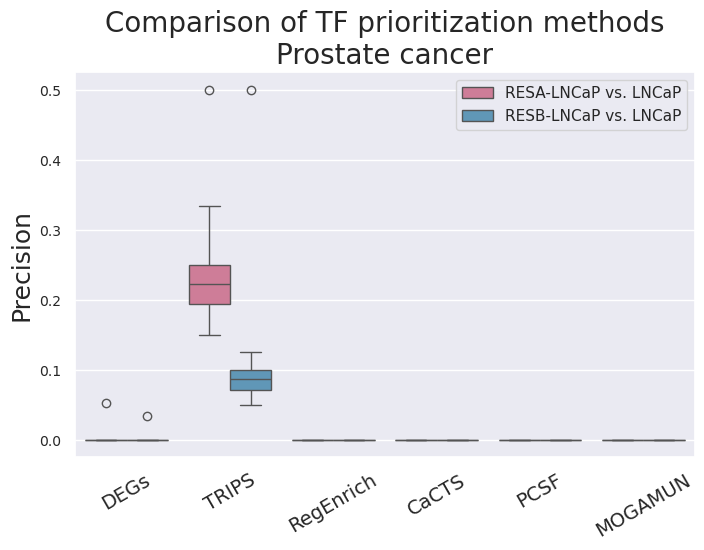

In [54]:
sns.set()
plt.figure(figsize=(8,5))
b = sns.boxplot(data=df_both,x="method", y="precision", hue="Comparison", palette=my_colors)  # RUN PLOT  
b.axes.set_title("Comparison of TF prioritization methods\nProstate cancer",
                 fontsize=20)
b.set_xlabel("",fontsize=18)
b.set_ylabel("Precision",fontsize=18)
b.tick_params(labelsize=5)

new_labels = ["DEGs","TRIPS","RegEnrich","CaCTS","PCSF","MOGAMUN"]
b.set_xticklabels(new_labels, rotation=30, fontsize=14)
b.set_yticklabels(b.get_yticklabels(), fontsize=10)

file = os.path.join(r"/data2/home/giga/TRIPS_results/ZENODO/single_cell_datasets", "evaluation_prostate_cancer.png")
plt.legend(loc="upper right")
plt.savefig(file, format="png", bbox_inches="tight")